## Feature Importance and Feature Selection


In [51]:
import opensmile 
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
smile_lld_ComParE = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors)

In [3]:
smile_functionals_ComParE = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals)

In [4]:
len(smile_lld_ComParE.feature_names), len(smile_functionals_ComParE.feature_names)

(65, 6373)

In [5]:
def load_files(path, smile_object):
    
    results = pd.DataFrame()
    
    for file in os.listdir(path):
        if file.endswith('.wav'):
            df = smile_object.process_file(os.path.join(path,file))
            results = pd.concat([results,df])
        
    return results

In [6]:
base_path = "/home/ubuntu/"

In [7]:
real_path = base_path + 'data/world-leaders-dataset/WavFiles/biden_wav_audio/44100KHz'
biden_df = load_files(real_path, smile_functionals_ComParE)
biden_df['label'] = 0

fake_path = base_path + 'data/world-leaders-dataset/11LabsDeepFakes'
fake_biden_df = load_files(fake_path, smile_functionals_ComParE)
fake_biden_df['label'] = 1

In [8]:
df = pd.concat([biden_df, fake_biden_df]).reset_index()
df = df.drop(columns=['file', 'start', 'end'])
df.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,label
0,4.703442,0.757979,0.317021,0.915155,1.601160,2.246375,0.686006,0.645215,1.331221,0.101343,...,0.614847,2.273842,2.270063,19.998241,0.636268,106.226677,50.793915,103.037048,52.213242,0
1,2.267536,0.028464,0.113483,0.238443,0.427879,0.663548,0.189437,0.235668,0.425105,0.059096,...,0.596789,2.498126,2.499365,-20.000000,0.483478,115.425087,57.748161,112.634346,58.922848,0
2,3.228675,0.078931,0.877564,0.276506,0.627168,0.960359,0.350661,0.333191,0.683852,0.107443,...,0.551893,2.649651,2.647956,19.999996,0.558275,115.258064,62.384377,119.572105,64.346001,0
3,2.391800,0.521424,0.720177,0.193181,0.444353,0.718777,0.251172,0.274424,0.525596,0.072356,...,0.594311,2.408087,2.408055,20.000000,0.565387,111.302612,51.976112,109.908424,54.466801,0
4,2.131366,0.672943,0.857552,0.221287,0.564615,0.886703,0.343328,0.322088,0.665416,0.126160,...,0.580128,2.398257,2.399142,-20.000000,0.575350,110.340683,54.816952,107.680603,54.231342,0


In [16]:
#df.to_csv("biden_opensmile_feats.csv", index=False)
df = pd.read_csv("biden_opensmile_feats.csv")

In [17]:
y = df['label'].copy()
X = df.drop(columns=['label']).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [18]:
#standard scaling of input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Feature Importance

Random forest regressor - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [19]:
#hyperparameter selection
n_estimators = 1000 #default=100
criterion = "gini" #{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth = 10 #default=None 
min_samples_split = 2 #default=2 The minimum number of samples required to split an internal node
min_samples_leaf = 1 #default=1 The minimum number of samples required to be at a leaf node.
min_weight_fraction_leaf = 0.0 #The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
max_features = "log2" #default="sqrt" The number of features to consider when looking for the best split:
max_leaf_nodes = None #Grow trees with max_leaf_nodes in best-first fashion.
min_impurity_decrease = 0.0 #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
bootstrap = True #default = True Whether bootstrap samples are used when building trees.
oob_score = True #default = False Whether to use out-of-bag samples to estimate the generalization score.
n_jobs = -1 #default=None -1 means all processors
random_state = None #deafult=None controls randomness of bootstrapping
verbose = 0 
warm_start = False #deafult = False When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
max_samples = None #If bootstrap is True, the number of samples to draw from X to train each base estimator.

In [20]:
#define model
model_rfc = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                                criterion=criterion,
                                max_features=max_features,
                                bootstrap=bootstrap,
                                oob_score=oob_score,
                                n_jobs=n_jobs)

#fit model
model_rfc.fit(X_train_scaled,y_train)

#get feature importance 
importance = model_rfc.feature_importances_

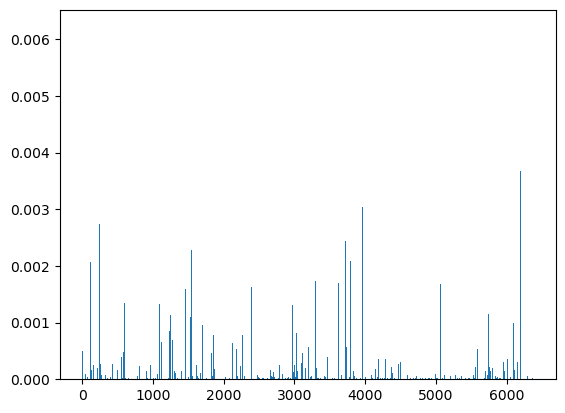

In [21]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [22]:
features = X.columns.to_list()
top_k_features = np.argsort(importance)[-50:]
tresh=importance[top_k_features[0]]
# summarize feature importance
for i,v in enumerate(importance):
    if v >= tresh:
        print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: audspec_lengthL1norm_sma_minPos, Score: 0.00504
Feature: pcm_RMSenergy_sma_minPos, Score: 0.00361
Feature: pcm_RMSenergy_sma_de_lpc0, Score: 0.00278
Feature: pcm_RMSenergy_sma_de_lpc1, Score: 0.00262
Feature: pcm_zcr_sma_de_lpgain, Score: 0.00401
Feature: pcm_zcr_sma_de_lpc2, Score: 0.00273
Feature: pcm_fftMag_spectralVariance_sma_lpc4, Score: 0.00261
Feature: pcm_fftMag_spectralSlope_sma_lpc0, Score: 0.00278
Feature: mfcc_sma[7]_lpgain, Score: 0.00332
Feature: mfcc_sma[7]_lpc0, Score: 0.00621
Feature: mfcc_sma[10]_lpgain, Score: 0.00384
Feature: mfcc_sma[10]_lpc0, Score: 0.00511
Feature: mfcc_sma[10]_lpc1, Score: 0.00309
Feature: mfcc_sma[11]_quartile1, Score: 0.00285
Feature: mfcc_sma[11]_quartile3, Score: 0.00288
Feature: audSpec_Rfilt_sma_de[10]_iqr1-2, Score: 0.00273
Feature: audSpec_Rfilt_sma_de[11]_quartile1, Score: 0.00276
Feature: audSpec_Rfilt_sma_de[11]_iqr1-2, Score: 0.00326
Feature: pcm_fftMag_spectralRollOff25.0_sma_de_risetime, Score: 0.00310
Feature: pcm_fftMag

## Feature Selection

In [23]:
# feature selection
def select_features(model, X_train, y_train, X_test):
	# configure to select a subset of features
	fs = SelectFromModel(model, max_features=50)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [24]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(model_rfc, X_train_scaled, y_train, X_test_scaled)

__Logistic Regression:__

In [25]:
# fit the model
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train_fs, y_train)
# evaluate the model
yhat = model_lr.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 100.00


__KNN Classifier:__

In [26]:
from sklearn.neighbors import KNeighborsClassifier

model_knnc = KNeighborsClassifier()
model_knnc.fit(X_train_fs, y_train)

# evaluate the model
yhat = model_knnc.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 100.00


## Test on in the wild deepfake

Biden twitter deepfake - https://twitter.com/Finanzas_Times/status/1626004270829928448?t=VU_2BRhMHvrNyms6jQnx8w&s=08

Biden reddit deepfake - https://www.reddit.com/r/shitposting/comments/1165xnx/now_thats_my_president/?utm_source=share&utm_medium=ios_app&utm_name=iossmf

In [27]:
jb_dfitw1 = base_path + "data/InTheWildFakes/Biden/Original/biden-reddit-fake.wav"
jb_dfitw2 = base_path + "data/InTheWildFakes/Biden/Original/biden-twitter-fake.wav"

In [28]:
jb_dfitw1_df = smile_functionals_ComParE.process_file(jb_dfitw1)
jb_dfitw1_df_scaled = scaler.transform(jb_dfitw1_df)

jb_dfitw2_df = smile_functionals_ComParE.process_file(jb_dfitw2)
jb_dfitw2_df_scaled = scaler.transform(jb_dfitw2_df)

In [29]:
model_lr.predict(fs.transform(jb_dfitw1_df_scaled)), model_knnc.predict(fs.transform(jb_dfitw1_df_scaled))

(array([1]), array([1]))

In [30]:
model_lr.predict(fs.transform(jb_dfitw2_df_scaled)), model_knnc.predict(fs.transform(jb_dfitw2_df_scaled))

(array([1]), array([1]))

In [31]:
jb_dfitw3 = base_path + "data/InTheWildFakes/Biden/Original/jb-twitter-2-df.wav"
jb_dfitw3_df = smile_functionals_ComParE.process_file(jb_dfitw3)
jb_dfitw3_df_scaled = scaler.transform(jb_dfitw3_df)

In [32]:
model_lr.predict(fs.transform(jb_dfitw3_df_scaled)), model_knnc.predict(fs.transform(jb_dfitw3_df_scaled))

(array([0]), array([0]))

In [155]:
jb_dfitw_all = pd.concat([pd.DataFrame(jb_dfitw1_df_scaled), pd.DataFrame(jb_dfitw2_df_scaled), pd.DataFrame(jb_dfitw3_df_scaled)]).reset_index()

## Visualization

In [184]:
real_idx = np.where(y_train.to_numpy() == 0)[0]
X_real = pd.DataFrame(X_train_fs[real_idx])
fake_idx = np.where(y_train.to_numpy() == 1)[0]
X_fake = pd.DataFrame(X_train_fs[fake_idx])
len(X_real), len(X_fake)

(195, 189)

In [193]:
X_tsne = pd.concat([X_real, X_fake]).reset_index()

In [200]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_tsne_2d = tsne.fit_transform(X_tsne)

/home/ubuntu/miniconda3/envs/deepfake-detection-v1/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


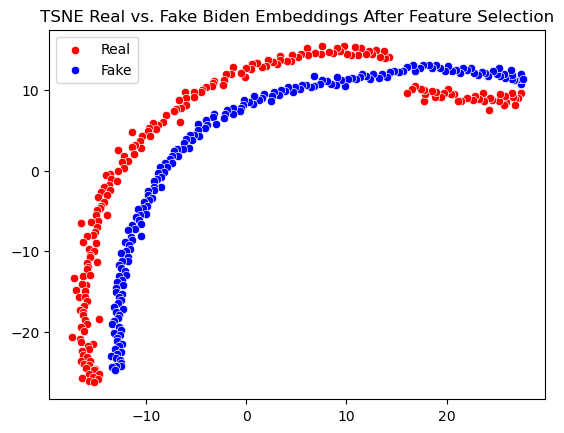

In [201]:
sns.scatterplot(x=X_tsne_2d[:195,0], y=X_tsne_2d[:195,1], color='red', label='Real')
sns.scatterplot(x=X_tsne_2d[195:384,0], y=X_tsne_2d[195:384,1], color='blue', label='Fake')
#sns.scatterplot(x=X_tsne_2d[384:,0], y=X_tsne_2d[384:,1], color='orange', label='ITW Fake')
plt.title('TSNE Real vs. Fake Biden Embeddings After Feature Selection')
plt.show()

In [188]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_tsne_2d = tsne.fit_transform(X)

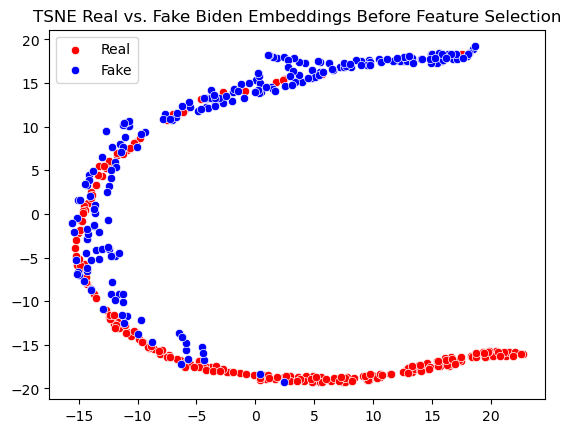

In [189]:
sns.scatterplot(x=X_tsne_2d[:214,0], y=X_tsne_2d[:214,1], color='red', label='Real')
sns.scatterplot(x=X_tsne_2d[214:,0], y=X_tsne_2d[214:,1], color='blue', label='Fake')
plt.title('TSNE Real vs. Fake Biden Embeddings Before Feature Selection')
plt.show()